In [2]:
import os
import sys
from typing import List


import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


ABS_PATH = %pwd
notebook_path = [idx for idx,ch in enumerate(ABS_PATH) if ch=='/']
notebooks_level_in_the_project = 1

PROJECT_PATH = ABS_PATH[:notebook_path[-notebooks_level_in_the_project]]
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)


config = ConfigProto()
config.gpu_options.allow_growth = True
InteractiveSession(config=config)

In [3]:
from src.data.requests_downloader import UrlDownloader
from src.features.dataset import Dataset
from src.features.metrics import CustomMeanIoU
from src.models.model_builder import Model
from src.visualization.visualize import PredictionMasks
from src.features.evaluation_utils import (
    PredictionIoU,
    ConfusionMatrix,
    HistoryUtilities,
    History
)
from src.features.loss_functions import SemanticSegmentationLoss

In [4]:
print(f"TensorFlow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

TensorFlow Version: 2.5.1

Python 3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
GPU is available


In [5]:
VERSION = '10.0'

BATCH_SIZE = 4
IMG_HEIGHT = 512
IMG_WIDTH = 512
NUM_CLASSES = 5

In [8]:
sys.path.insert(0, '/app')

In [12]:
! python3 models/scripts/run_prediction_on_folder.py --checkpoint-to-load "/app/notebooks/templates/results/DeepLabv3+/10.0/best_dice_loss/checkpoint"


python3: can't open file 'models/scripts/run_prediction_on_folder.py': [Errno 2] No such file or directory


# Load datasets

In [5]:
UrlDownloader().download_project_preprocessed_dataset()

Previously unzipped files exists.


In [6]:
DATASET_PATH = os.path.join(PROJECT_PATH, 'data/processed')
landcover_dataset = Dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, BATCH_SIZE)
train_dataset, val_dataset, test_dataset = landcover_dataset.generate_datasets()

print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))
print("Test Dataset:", test_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(test_dataset))

Train Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 5)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7468
Val Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 5)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1600
Test Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 5)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1600


# Class balance 

,class_number,pixel_count
background,0,1.626436e+09
buildings,1,2.456691e+07
woodland,2,9.256445e+08
water,3,1.757691e+08
roads,4,4.570887e+07


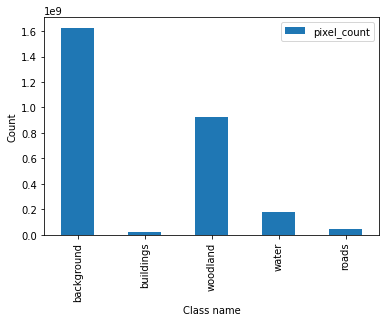

In [7]:
landcover_dataset.get_dataframe_of_previously_calculated_class_balance_class_balance().plot.bar(y="pixel_count", xlabel="Class name", ylabel="Count")
landcover_dataset.get_dataframe_of_previously_calculated_class_balance_class_balance()

# Evaluation utilities

In [8]:
custom_mIoU_metric = CustomMeanIoU(num_classes=NUM_CLASSES, name='mIoU')

## Callbacks
### Model checkpoint

In [9]:
def create_folders(paths: List[str]):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)

In [10]:
path_best_dice_loss = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_dice_loss/checkpoint'
dir_path_dice_loss= PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_dice_loss'
path_best_miou = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_miou/checkpoint'
dir_path_miou = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_miou'


create_folders([
    dir_path_dice_loss,
    dir_path_miou,
])

In [11]:
best_val_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

best_miou = tf.keras.callbacks.ModelCheckpoint(
    path_best_miou,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

### Early stopping

In [12]:
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3,
                                                           mode='min')

### Learning rate schedule [optimizer]

In [13]:
EPOCHS = 20

NUM_TRAIN_IMAGES = BATCH_SIZE * len(train_dataset)
NUM_VAL_IMAGES = BATCH_SIZE * len(val_dataset)

initial_learning_rate = 0.001
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/EPOCHS)
steps_per_epoch = int(NUM_TRAIN_IMAGES/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

### Get current lr [metric]

In [14]:
#  https://stackoverflow.com/questions/47490834/how-can-i-print-the-learning-rate-at-each-epoch-with-adam-optimizer-in-keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer_adam)

## Training settings

In [15]:
# creating a model
WEIGHTS = "cityscapes"
SHOULD_FREEZE_LAYERS = True
LAST_LAYER_TO_FREEZE = 359  # All from the begining up to 359 will be frozen
ACTIVATION = "softmax"
DEEPLAB_VERSION = "deeplabv3plus"
OUTPUT_STRIDE = 16  # or 8

# compiling the model
if optimizer_adam:
    OPTIMIZER = optimizer_adam
else:
    OPTIMIZER = tf.keras.optimizers.Adam(initial_learning_rate)

LOSS = SemanticSegmentationLoss(NUM_CLASSES).soft_dice_loss
METRICS = ["accuracy", custom_mIoU_metric]

# training the model
EPOCHS = 40
TRAINING_DATA_PATH = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}'
CALLBACKS = [
    early_stopping_val_loss,
    best_val_loss,
    best_miou
]


## Training

 DeepLabv3+ model architecture

https://keras.io/examples/vision/deeplabv3_plus/

In [16]:
revision = f"{VERSION}.1"
revision

'10.0.1'

In [17]:
deeplab_model = Model(
    revision=revision,
    batch_size=BATCH_SIZE,
    input_image_height=IMG_HEIGHT,
    input_image_width=IMG_WIDTH,
    number_of_classes=NUM_CLASSES,
    pretrained_weights=WEIGHTS,
    do_freeze_layers=SHOULD_FREEZE_LAYERS,
    last_layer_frozen=LAST_LAYER_TO_FREEZE,
    activation=ACTIVATION,
    model_architecture=DEEPLAB_VERSION,
    output_stride=OUTPUT_STRIDE,
    optimizer=OPTIMIZER,
    loss_function=LOSS,
    metrics=METRICS
)
deeplab_model.save_model_revision(
        initial_learning_rate=initial_learning_rate,
        final_learning_rate=final_learning_rate
)

model = deeplab_model.get_deeplab_model()
model.compile(*deeplab_model.get_compile_parameters)

# tf.keras.utils.plot_model(model, to_file=data_save_dir + '/Deeplabv3plus_v8_5.jpg', show_shapes=True)

In [18]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

Epoch 1/40
1867/1867 [==============================] - 499s 265ms/step - loss: 0.6838 - accuracy: 0.7721 - mIoU: 0.4540 - val_loss: 0.6700 - val_accuracy: 0.7962 - val_mIoU: 0.4956

Epoch 00001: val_loss improved from inf to 0.66997, saving model to /app/notebooks/templates/results/DeepLabv3+/10.0/best_dice_loss/checkpoint

Epoch 00001: val_mIoU improved from -inf to 0.49559, saving model to /app/notebooks/templates/results/DeepLabv3+/10.0/best_miou/checkpoint
Epoch 2/40
1867/1867 [==============================] - 497s 266ms/step - loss: 0.6516 - accuracy: 0.8444 - mIoU: 0.5601 - val_loss: 0.6760 - val_accuracy: 0.8002 - val_mIoU: 0.5264

Epoch 00002: val_loss did not improve from 0.66997

Epoch 00002: val_mIoU improved from 0.49559 to 0.52639, saving model to /app/notebooks/templates/results/DeepLabv3+/10.0/best_miou/checkpoint
Epoch 3/40
1867/1867 [==============================] - 500s 268ms/step - loss: 0.6340 - accuracy: 0.8757 - mIoU: 0.6201 - val_loss: 0.6676 - val_accuracy: 0

KeyboardInterrupt: 

### Save history to file

In [19]:
history_utils = HistoryUtilities()
history_utils.dump_model_history_to_file(history, TRAINING_DATA_PATH, "history")

History([history]).display_history_plots()

NameError: name 'history' is not defined

## Evaluate the model

In [20]:
model.load_weights(path_best_dice_loss)

In [ ]:
iou_every_class = PredictionIoU(model, test_dataset, NUM_CLASSES).get_iou_for_every_class()
iou_every_class

In [ ]:
PredictionMasks(model, landcover_dataset, NUM_CLASSES).display_overlay_predictions_for_test_set(4, (25, 25))

### Confusion matrix

In [21]:
class_names = ['background', 'buildings', 'woodland', 'water', 'roads']

confusion_matrix = ConfusionMatrix(model, test_dataset, NUM_CLASSES)
confusion_matrix.display_confusion_matrix(class_names)

KeyboardInterrupt: 

In [22]:
model.evaluate(test_dataset)

400/400 [==============================] - 63s 157ms/step - loss: 0.2981 - accuracy: 0.8467 - mIoU: 0.3722


[0.29807135462760925, 0.8466689586639404, 0.37224510312080383]

# Further training the model
## You may change the settings
E.g. Freeze less layers, change optimizer's learning rate, add metric, etc.

In [ ]:
break
revision = f"{VERSION}.2"
revision

In [ ]:
deeplab_model = Model(
    revision=revision,
    batch_size=BATCH_SIZE,
    input_image_height=IMG_HEIGHT,
    input_image_width=IMG_WIDTH,
    number_of_classes=NUM_CLASSES,
    pretrained_weights=WEIGHTS,
    do_freeze_layers=SHOULD_FREEZE_LAYERS,
    last_layer_frozen=LAST_LAYER_TO_FREEZE,  # freeze 40 layers less
    activation=ACTIVATION,
    model_architecture=DEEPLAB_VERSION,
    output_stride=OUTPUT_STRIDE,
    optimizer=OPTIMIZER,
    loss_function=LOSS,
    metrics=METRICS
)

deeplab_model.save_model_revision(
    initial_learning_rate=initial_learning_rate,
    final_learning_rate=final_learning_rate
)

model = deeplab_model.get_deeplab_model()
model.compile(*deeplab_model.get_compile_parameters)
model.load_weights(path_best_dice_loss)

# tf.keras.utils.plot_model(model, to_file=data_save_dir + '/Deeplabv3plus_v8_5.jpg', show_shapes=True)

In [ ]:
# load weights with best results
history_2 = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

In [ ]:
History([history, history_2]).display_history_plots(TRAINING_DATA_PATH)